# Combined Titanic Submission

## Import / Read In CSV Files

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("datasets/titanicdata/train.csv")
test = pd.read_csv("datasets/titanicdata/test.csv")

## Helper Function to Split Data

In [2]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
cut_points = [-1,0, 5, 12, 18, 35, 60, 100]
label_names = ["Missing", 'Infant', "Child", 'Teenager', "Young Adult", 'Adult', 'Senior']

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")
train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")
train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,1,0,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,0,0,0,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,1,0,0,0,0,1,0,0


## Show Age Categories

### Age Groups

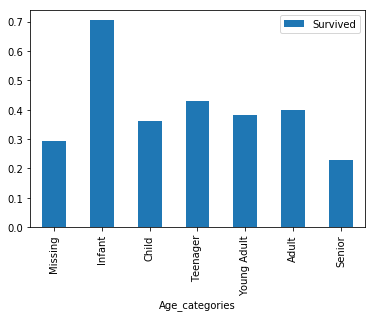

In [4]:
age_cat_pivot = train.pivot_table(index="Age_categories",values="Survived")
age_cat_pivot.plot.bar()
plt.show()

### Histogram of Deaths by Age

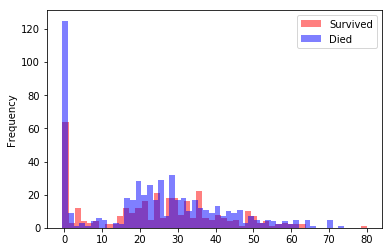

In [5]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

## Adding Crew

In [7]:
train['Crew?'] = [1 if x == 0.0 else 0 for x in train['Fare']]
test['Crew?'] = [1 if x == 0.0 else 0 for x in test['Fare']]
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Crew?
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,0,0,0,0,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,0,0,0,0,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,0,0,1,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,0,0,0,1,0,0,0


## Alone?

In [9]:
for x in range(891):
    train["Alone?"] = 0
for x in range(891):
    if train.at[x, "Parch"] == 0 and train.at[x, "SibSp"] == 0:
        train.at[x, "Alone?"] = 1
    else:
        train.at[x, "Alone?"] = 0
        
for x in range(891):
    test["Alone?"] = 0
for x in range(418):
    if test.at[x, "Parch"] == 0 and test.at[x, "SibSp"] == 0:
        test.at[x, "Alone?"] = 1
    else:
        test.at[x, "Alone?"] = 0

# Testing

In [10]:
from sklearn.model_selection import cross_val_score
import numpy as np

from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn import tree


columns = ['Pclass_1', 'Pclass_3', 'Sex_female',
       'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Adult',
       'Age_categories_Senior', 'Alone?', 'Crew?']

all_X = train[columns] 
all_y = train['Survived']

dt = tree.DecisionTreeClassifier(
    max_depth = 7,
    min_samples_split = 2,
    random_state = 1
    )

lr = LogisticRegression(solver="lbfgs")
p = Perceptron(max_iter=1000, tol=1e-3)
s = SGDClassifier(tol=1e-3)
lscores = cross_val_score(lr, all_X, all_y, cv=10)
pscores = cross_val_score(p, all_X, all_y, cv=10)
sscores = cross_val_score(s, all_X, all_y, cv=10)
tscores = cross_val_score(dt, all_X, all_y, cv=10)
print("Logistic Mean: ", np.mean(lscores))
print("Perceptron Mean: ", np.mean(pscores))
print("SGDC Classifier Mean: ", np.mean(sscores))
print("Decision Tree Mean: ", np.mean(tscores))


Logistic Mean:  0.8001949267960503
Perceptron Mean:  0.7623045057314719
SGDC Classifier Mean:  0.7981352854386562
Decision Tree Mean:  0.8226290999886505


In [15]:
dt = tree.DecisionTreeClassifier(
    max_depth = 7,
    min_samples_split = 2,
    random_state = 1
    )

lr = LogisticRegression(solver = 'lbfgs')
dt.fit(all_X, all_y)
lr.fit(all_X, all_y)

holdout_predictions = lr.predict(test[columns])
holdout_predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

## Creating Submission File

In [16]:
ids = test["PassengerId"]
submission_df = {"PassengerId": ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv('titanic_submission.csv', index=False)